
# Tech Challenge — Classificação Direcional do Ibovespa (t+1)

**Objetivo:** prever se o fechamento do **dia útil seguinte (t+1)** ficará **acima (sobe)** ou **igual/abaixo (não sobe)** em relação ao fechamento do **dia t**.

**Regra do projeto:** o **conjunto de teste** deve ser **exatamente os 30 pregões finais disponíveis** na base (ex.: 10/09/2025 → 21/10/2025).

**O que este notebook entrega:**
- Leitura **PT-BR** do CSV (datas `DD.MM.AAAA`, ponto = milhar, vírgula = decimal, `%`, sufixos `K/M/B` em volume);
- **EDA** com checagens e gráficos simples;
- **Feature Engineering** (retornos, médias móveis, afastamentos, volatilidades, RSI, Stochastic %K, variação de volume, dia da semana);
- **Limpeza**, **Padronização** (quando faz sentido) e **split temporal** (treino vs. **teste = 30 pregões finais**);
- **Modelos separados**: Regressão Logística, **SVM Linear**, **SVM RBF**, **KNN**, **Árvore de Decisão**, **Random Forest**;
- **Validação temporal** (*TimeSeriesSplit*) + **GridSearch enxuto** (nível intermediário);
- **Métricas** (Acurácia, Precisão, Revocação, F1, **ROC/AUC**, **Matriz de Confusão**);
- **Storytelling técnico** e **justificativas** em linguagem de apresentação;
- **Previsão final** para **22/10/2025** usando informações até **21/10/2025**.

> Observação: *não há “espiada no futuro”*. Todos os atributos em `t` usam somente dados até `t`.



## 1) EDA — visão geral e por que importa
- **Cobertura** (linhas, data mínima/máxima), porcentagem de **faltantes** e **consistência intradiária** (mín ≤ último ≤ máx);
- **Série do fechamento**: tendência, ciclos e choques;
- **Histograma de retornos diários**: assimetria/caudas (dias atípicos);
- **O que isso significa:** regimes e choques afetam previsibilidade; retornos têm cauda — precisamos de métricas robustas no teste.


In [23]:

# Imports e configurações
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [24]:

# Funções auxiliares (PT-BR, indicadores e gráficos)
def parse_ptbr_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace('.', '').replace(',', '.')
    try: return float(s)
    except: return np.nan

def parse_volume_str(s):
    if pd.isna(s): return np.nan
    s = str(s).strip()
    mult = 1.0
    if s.endswith('B'): mult = 1_000_000_000; s = s[:-1]
    elif s.endswith('M'): mult = 1_000_000; s = s[:-1]
    elif s.endswith('K'): mult = 1_000; s = s[:-1]
    val = parse_ptbr_number(s)
    return val * mult if val is not None else np.nan

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)
    gain_sma = pd.Series(gain, index=series.index).rolling(window).mean()
    loss_sma = pd.Series(loss, index=series.index).rolling(window).mean()
    rs = gain_sma / (loss_sma.replace(0, np.nan))
    return 100 - (100 / (1 + rs))

def compute_stochastic_k(high, low, close, k_window=14, smooth=3):
    low_min = low.rolling(k_window).min()
    high_max = high.rolling(k_window).max()
    raw_k = 100 * (close - low_min) / (high_max - low_min)
    return raw_k.rolling(smooth).mean()

def plot_confusion_matrix(cm, classes, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center")
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = roc_auc_score(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


Linhas: 1741
Data mínima: 2018-10-22  | Data máxima: 2025-10-21

Faltantes (%):
Data        0.0000
Ultimo      0.0000
Abertura    0.0000
Maxima      0.0000
Minima      0.0000
Vol         0.0000
VarPct      0.0000
ret_d1      0.0006
dtype: float64


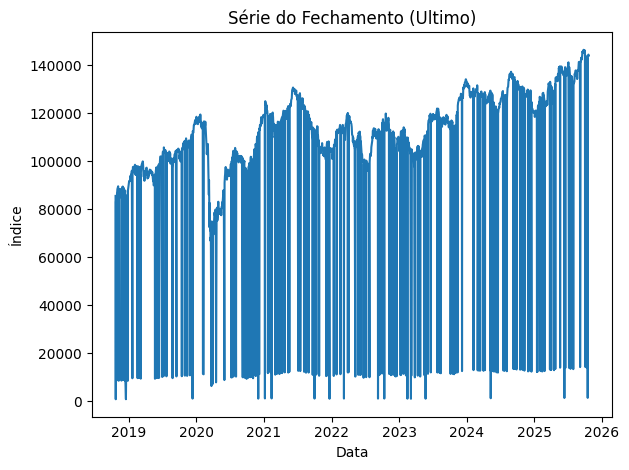

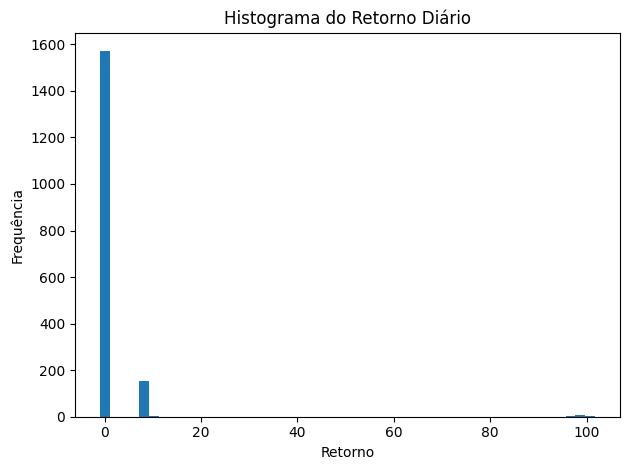


Inconsistências Min<=Ultimo<=Max: 331


In [25]:

# 1) Leitura do CSV (PT-BR) e EDA básica
csv_path = 'Ibovespa.csv'
df_raw = pd.read_csv(csv_path).rename(columns={'Data':'Data','Último':'Ultimo','Abertura':'Abertura','Máxima':'Maxima','Mínima':'Minima','Vol.':'Vol','Var%':'VarPct'})

df_raw['Data'] = pd.to_datetime(df_raw['Data'], format='%d.%m.%Y', errors='coerce')
for col in ['Ultimo','Abertura','Maxima','Minima']:
    df_raw[col] = df_raw[col].apply(parse_ptbr_number)
df_raw['Vol'] = df_raw['Vol'].apply(parse_volume_str)
df_raw['VarPct'] = df_raw['VarPct'].astype(str).str.replace('%','')
df_raw['VarPct'] = df_raw['VarPct'].apply(parse_ptbr_number)/100.0

# Ordenar do mais antigo ao mais recente
df_raw = df_raw.sort_values('Data').reset_index(drop=True)

# Retorno diário para EDA
df_raw['ret_d1'] = df_raw['Ultimo'].pct_change()

print('Linhas:', len(df_raw))
print('Data mínima:', df_raw['Data'].min().date(), ' | Data máxima:', df_raw['Data'].max().date())
print('\nFaltantes (%):')
print(df_raw.isna().mean().round(4))

# Gráficos simples
plt.figure()
plt.plot(df_raw['Data'], df_raw['Ultimo'])
plt.title('Série do Fechamento (Ultimo)')
plt.xlabel('Data'); plt.ylabel('Índice')
plt.tight_layout(); plt.show()

plt.figure()
plt.hist(df_raw['ret_d1'].dropna(), bins=50)
plt.title('Histograma do Retorno Diário')
plt.xlabel('Retorno'); plt.ylabel('Frequência')
plt.tight_layout(); plt.show()

# Checagem de consistência intradiária
if set(['Minima','Ultimo','Maxima']).issubset(df_raw.columns):
    consistent = (df_raw['Minima'] <= df_raw['Ultimo']) & (df_raw['Ultimo'] <= df_raw['Maxima'])
    print('\nInconsistências Min<=Ultimo<=Max:', int((~consistent).sum()))



## 2) Feature Engineering — o que é e por que criamos
- **Retornos** (`ret_d1`, `ret_5d`, `ret_10d`): capturam **momentum** curto;
- **Médias móveis** e **afastamento** (`mm_5/10/20`, `dist_mm5/10/20`): **tendência** e “esticamento” do preço;
- **Volatilidades** (`vol_5/10`): **ambiente** (ruído) do mercado;
- **Indicadores clássicos** (`RSI_14`, `STOK_14_3`): força/posição do preço no range recente;
- **Volume** (`dV`): picos costumam antecipar reversões/continuidade;
- **Calendário** (`dow_*`): padrões sistemáticos por **dia da semana**.


In [26]:

# 2) Feature Engineering
df = df_raw.copy()

for w in [5,10,20]:
    df[f"mm_{w}"] = df['Ultimo'].rolling(w).mean()
    df[f"dist_mm{w}"] = df['Ultimo'] - df[f"mm_{w}"]

for w in [5,10]:
    df[f"vol_{w}"] = df['ret_d1'].rolling(w).std()

df['RSI_14'] = compute_rsi(df['Ultimo'], window=14)
df['STOK_14_3'] = compute_stochastic_k(df['Maxima'], df['Minima'], df['Ultimo'], 14, 3)
df['dV'] = df['Vol'].pct_change()
df['ret_5d'] = df['Ultimo'].pct_change(5)
df['ret_10d'] = df['Ultimo'].pct_change(10)
df['dow'] = df['Data'].dt.dayofweek
dow_dummies = pd.get_dummies(df['dow'], prefix='dow')

df_features = pd.concat([
    df[['Data','Ultimo','Abertura','Maxima','Minima','Vol','ret_d1','ret_5d','ret_10d',
        'mm_5','mm_10','mm_20','dist_mm5','dist_mm10','dist_mm20','vol_5','vol_10',
        'RSI_14','STOK_14_3','dV']],
    dow_dummies
], axis=1)

# Alvo binário: 1 se próximo dia fecha acima do dia atual
df_features['y'] = (df_features['Ultimo'].shift(-1) > df_features['Ultimo']).astype(int)

# Remover NaNs oriundos das janelas e última linha (que não tem y)
df_model = df_features.dropna().copy()

print('df_model shape:', df_model.shape)


df_model shape: (1722, 26)



## 3) Split temporal (sem embaralhar) e alvo
- **Alvo binário:** `y_t = 1` se `Close_{t+1} > Close_t`, senão `0`.
- **Split:** **treino** = todo o passado **antes** dos 30 pregões finais; **teste** = **30 pregões finais** da base (exigência do projeto).
- **Validação:** `TimeSeriesSplit` (K-fold temporal) no **treino** para pequenos grids.


In [27]:

# 3) Split temporal (últimos 30 pregões no TESTE)
unique_dates = df_model['Data'].sort_values().unique()
test_dates = unique_dates[-30:]
train_dates = unique_dates[:-30]

train_df = df_model[df_model['Data'].isin(train_dates)].copy()
test_df  = df_model[df_model['Data'].isin(test_dates)].copy()

X_cols_cont = ['ret_d1','ret_5d','ret_10d','mm_5','mm_10','mm_20','dist_mm5','dist_mm10','dist_mm20',
               'vol_5','vol_10','RSI_14','STOK_14_3','dV','Vol','Abertura','Maxima','Minima','Ultimo']
X_cols_dow = [c for c in df_model.columns if c.startswith('dow_')]
X_cols = [c for c in X_cols_cont + X_cols_dow if c in df_model.columns]

X_train, y_train = train_df[X_cols], train_df['y']
X_test,  y_test  = test_df[X_cols],  test_df['y']

print('Treino:', train_df['Data'].min().date(), '→', train_df['Data'].max().date(), '| n =', len(train_df))
print('Teste:',  test_df['Data'].min().date(),  '→', test_df['Data'].max().date(),  '| n =', len(test_df))

# Baselines para contexto
baseline_always_up = np.ones_like(y_test)
baseline_same_sign = (test_df['ret_d1'] > 0).astype(int).values

print('\nBaselines (ACC): sempre sobe =', (baseline_always_up == y_test).mean(),
      '| sinal do dia =', (baseline_same_sign == y_test).mean())


Treino: 2018-11-21 → 2025-09-09 | n = 1692
Teste: 2025-09-10 → 2025-10-21 | n = 30

Baselines (ACC): sempre sobe = 0.5 | sinal do dia = 0.36666666666666664



## 4) Modelos — separados, simples e com justificativa
- **Regressão Logística** (baseline interpretável) — *pode falhar em não linearidades*;
- **SVM Linear** — separação aproximadamente linear;
- **SVM RBF** — capta **não linearidades** (candidato forte);
- **KNN** — padrões locais; sensível a escala/ruído;
- **Árvore de Decisão** — regras interpretáveis; risco de overfitting se profunda;
- **Random Forest** — robusta, boa de primeira; menos interpretável.


In [28]:

# Função de avaliação padronizada (gera métricas e gráficos)
def eval_and_report(name, estimator, X_train, y_train, X_test, y_test, probas_ok=True):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    try:
        y_score = estimator.predict_proba(X_test)[:,1] if probas_ok else None
    except Exception:
        try:
            # usa decision_function e normaliza 0..1 apenas para AUC/ROC
            raw = estimator.decision_function(X_test)
            y_score = (raw - raw.min())/(raw.max()-raw.min()+1e-9)
        except Exception:
            y_score = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_score) if y_score is not None else float('nan')

    print(f"\n=== {name} ===")
    print({'Acuracia':acc, 'Precisao':prec, 'Revocacao':rec, 'F1':f1, 'AUC':auc})

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['0 (Não Sobe)','1 (Sobe)'], f'Matriz de Confusão — {name}')

    if y_score is not None:
        plot_roc(y_test, y_score, f'Curva ROC — {name}')

    return {'Modelo':name, 'Acuracia':acc, 'Precisao':prec, 'Revocacao':rec, 'F1':f1, 'AUC':auc}


Melhor Logística: {'clf__C': 0.1}

=== Logistic Regression ===
{'Acuracia': 0.6, 'Precisao': 1.0, 'Revocacao': 0.2, 'F1': 0.3333333333333333, 'AUC': np.float64(0.6755555555555556)}


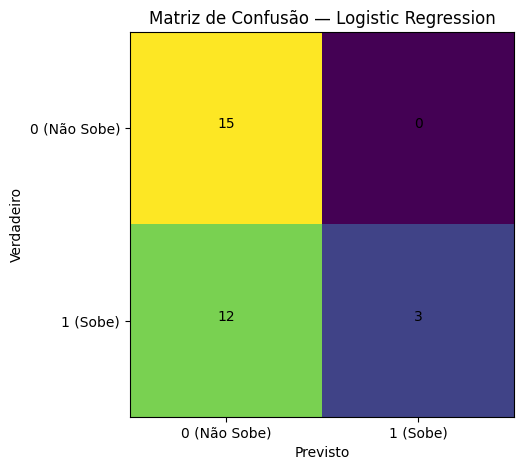

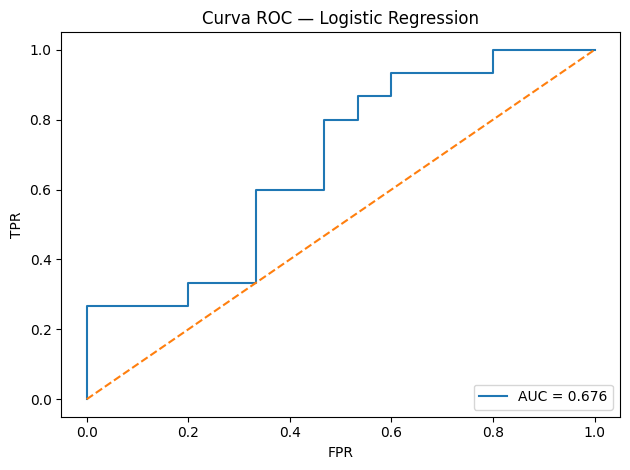

In [29]:

# 4.1) Regressão Logística — Pipeline (com padronização) + grid pequeno
tscv = TimeSeriesSplit(n_splits=5)
pipe_log = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=300, penalty='l2'))])
param_log = {'clf__C':[0.1, 1.0, 10.0]}

gs_log = GridSearchCV(pipe_log, param_grid=param_log, cv=tscv, scoring='f1', n_jobs=1)
gs_log.fit(X_train, y_train)
print('Melhor Logística:', gs_log.best_params_)
res_log = eval_and_report('Logistic Regression', gs_log.best_estimator_, X_train, y_train, X_test, y_test, probas_ok=True)


Melhor SVM Linear: {'clf__C': 1.0}

=== SVM (Linear) ===
{'Acuracia': 0.6333333333333333, 'Precisao': 1.0, 'Revocacao': 0.26666666666666666, 'F1': 0.42105263157894735, 'AUC': np.float64(0.5555555555555556)}


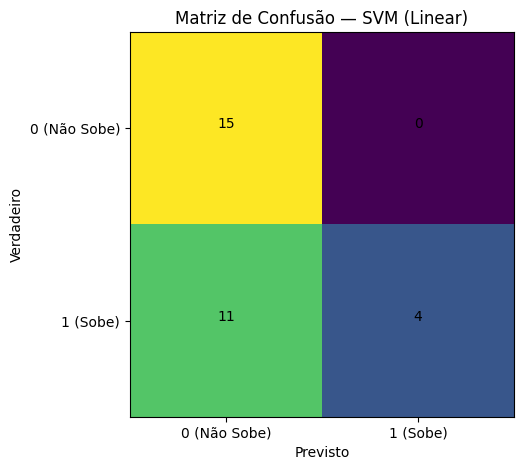

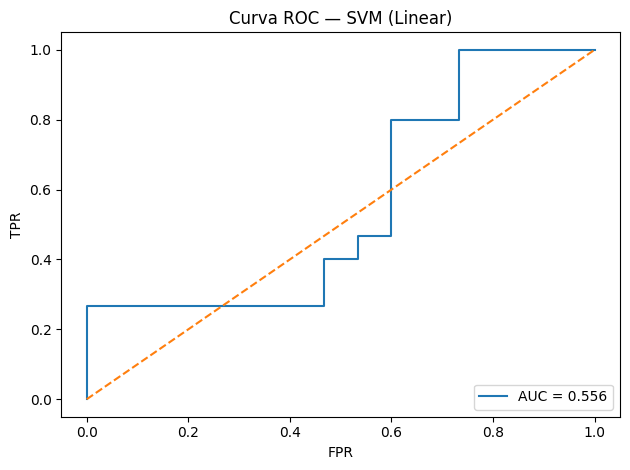

In [30]:

# 4.2) SVM Linear — Pipeline (padronização) + grid pequeno
pipe_svm_lin = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='linear', probability=True))])
param_svm_lin = {'clf__C':[0.1, 1.0, 10.0]}

gs_svm_lin = GridSearchCV(pipe_svm_lin, param_grid=param_svm_lin, cv=tscv, scoring='f1', n_jobs=1)
gs_svm_lin.fit(X_train, y_train)
print('Melhor SVM Linear:', gs_svm_lin.best_params_)
res_svm_lin = eval_and_report('SVM (Linear)', gs_svm_lin.best_estimator_, X_train, y_train, X_test, y_test, probas_ok=True)


Melhor SVM RBF: {'clf__C': 100.0, 'clf__gamma': 'scale'}

=== SVM (RBF) ===
{'Acuracia': 0.8, 'Precisao': 0.8, 'Revocacao': 0.8, 'F1': 0.8, 'AUC': np.float64(0.7466666666666668)}


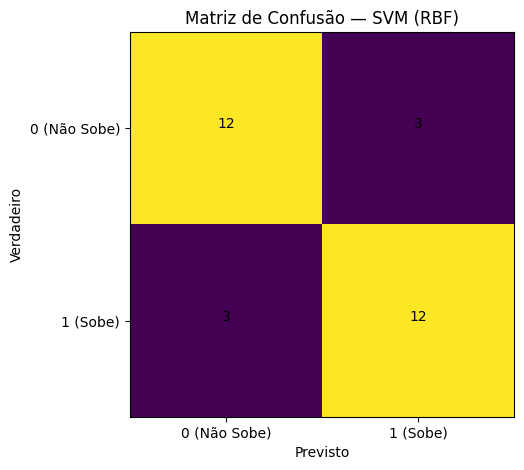

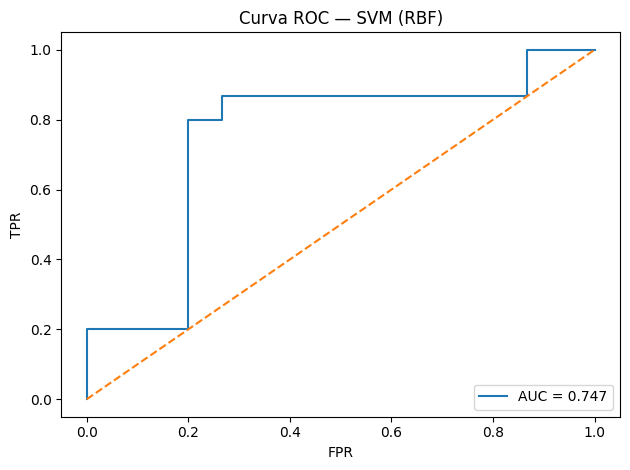

In [31]:

# 4.3) SVM RBF — Pipeline (padronização) + grid enxuto
pipe_svm_rbf = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', probability=True))])
param_svm_rbf = {'clf__C':[1.0, 10.0, 100.0], 'clf__gamma':['scale','auto']}

gs_svm_rbf = GridSearchCV(pipe_svm_rbf, param_grid=param_svm_rbf, cv=tscv, scoring='f1', n_jobs=1)
gs_svm_rbf.fit(X_train, y_train)
print('Melhor SVM RBF:', gs_svm_rbf.best_params_)
res_svm_rbf = eval_and_report('SVM (RBF)', gs_svm_rbf.best_estimator_, X_train, y_train, X_test, y_test, probas_ok=True)


Melhor KNN: {'clf__n_neighbors': 5, 'clf__weights': 'uniform'}

=== KNN ===
{'Acuracia': 0.5666666666666667, 'Precisao': 0.5625, 'Revocacao': 0.6, 'F1': 0.5806451612903226, 'AUC': np.float64(0.6844444444444444)}


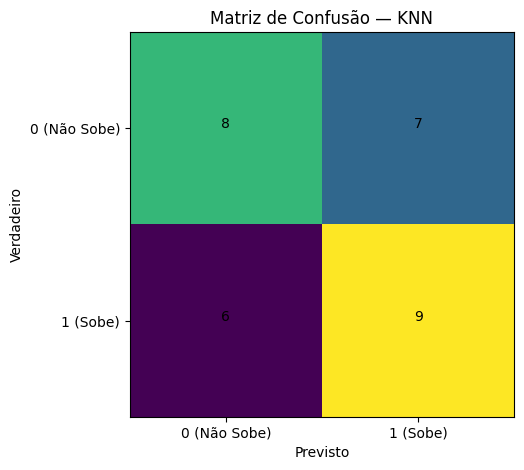

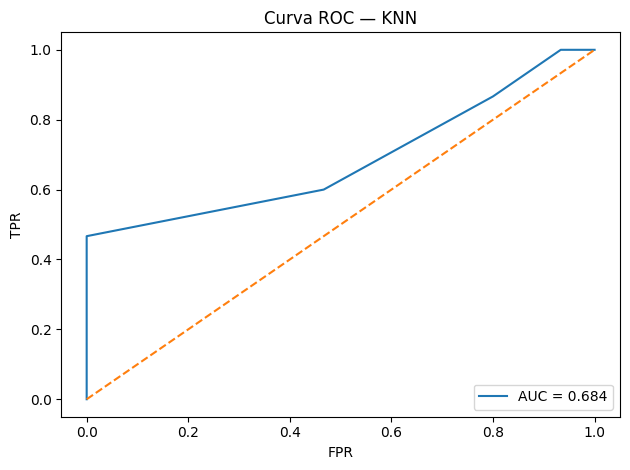

In [32]:

# 4.4) KNN — Pipeline (padronização) + grid curto
pipe_knn = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
param_knn = {'clf__n_neighbors':[5,11,21], 'clf__weights':['uniform','distance']}

gs_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=tscv, scoring='f1', n_jobs=1)
gs_knn.fit(X_train, y_train)
print('Melhor KNN:', gs_knn.best_params_)
res_knn = eval_and_report('KNN', gs_knn.best_estimator_, X_train, y_train, X_test, y_test, probas_ok=True)


Melhor Árvore: {'max_depth': 8, 'min_samples_leaf': 20}

=== Decision Tree ===
{'Acuracia': 0.6666666666666666, 'Precisao': 0.7777777777777778, 'Revocacao': 0.4666666666666667, 'F1': 0.5833333333333334, 'AUC': nan}


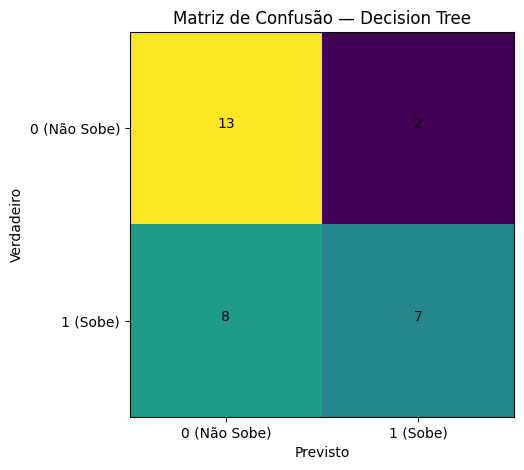

In [33]:

# 4.5) Árvore de Decisão — grid curto
tree = DecisionTreeClassifier(random_state=42)
param_tree = {'max_depth':[3,5,8], 'min_samples_leaf':[5,20]}

gs_tree = GridSearchCV(tree, param_grid=param_tree, cv=tscv, scoring='f1', n_jobs=1)
gs_tree.fit(X_train, y_train)
print('Melhor Árvore:', gs_tree.best_params_)
res_tree = eval_and_report('Decision Tree', gs_tree.best_estimator_, X_train, y_train, X_test, y_test, probas_ok=False)


Melhor RF: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 600}

=== Random Forest ===
{'Acuracia': 0.6333333333333333, 'Precisao': 1.0, 'Revocacao': 0.26666666666666666, 'F1': 0.42105263157894735, 'AUC': np.float64(0.6088888888888888)}


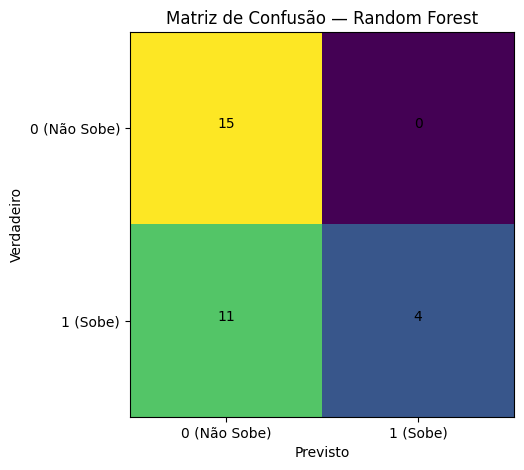

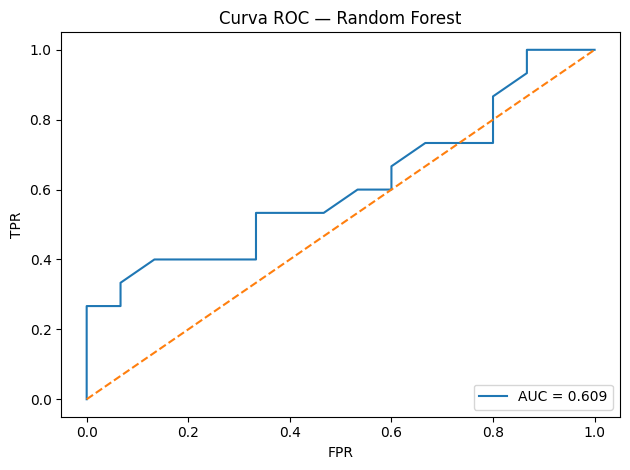

In [34]:

# 4.6) Random Forest — grid curto
rf = RandomForestClassifier(random_state=42, n_jobs=1)
param_rf = {'n_estimators':[300,600], 'max_depth':[8, None], 'min_samples_leaf':[1,5]}

gs_rf = GridSearchCV(rf, param_grid=param_rf, cv=tscv, scoring='f1', n_jobs=1)
gs_rf.fit(X_train, y_train)
print('Melhor RF:', gs_rf.best_params_)
res_rf = eval_and_report('Random Forest', gs_rf.best_estimator_, X_train, y_train, X_test, y_test, probas_ok=True)



## 5) Métricas e visualizações
- **Acurácia, Precisão, Revocação, F1** (no TESTE de 30 pregões);
- **ROC/AUC** (modelos probabilísticos) e **Matriz de confusão**;
- **Baselines**: “sempre sobe” e “sinal do dia” para contextualizar.


In [35]:

# 5) Consolidar métricas (TESTE) e escolher vencedor
results = pd.DataFrame([res_log, res_svm_lin, res_svm_rbf, res_knn, res_tree, res_rf])
results = results.sort_values(['Acuracia','F1'], ascending=[False, False]).reset_index(drop=True)
print('\nResumo (ordenado por Acurácia e F1):')
display(results)

# Regra do projeto: Acurácia >= 0.75; em empates, priorizar maior F1
best_row = results.iloc[0].to_dict()
print('\nVencedor:', best_row)



Resumo (ordenado por Acurácia e F1):


,Modelo,Acuracia,Precisao,Revocacao,F1,AUC
0,SVM (RBF),0.800000,0.800000,0.800000,0.800000,0.746667
1,Decision Tree,0.666667,0.777778,0.466667,0.583333,NaN
2,SVM (Linear),0.633333,1.000000,0.266667,0.421053,0.555556
3,Random Forest,0.633333,1.000000,0.266667,0.421053,0.608889
4,Logistic Regression,0.600000,1.000000,0.200000,0.333333,0.675556
5,KNN,0.566667,0.562500,0.600000,0.580645,0.684444



Vencedor: {'Modelo': 'SVM (RBF)', 'Acuracia': 0.8, 'Precisao': 0.8, 'Revocacao': 0.8, 'F1': 0.8, 'AUC': 0.7466666666666668}



## 6) Seleção e trade-offs
- **Meta**: **Acurácia ≥ 75%** no **TESTE**;
- **Empate** de acurácia: escolher maior **F1** (seu critério);
- **Ajustes simples** se precisar subir performance:
  - Logística/SVM: aumentar `C` (↓ regularização) — *trade-off:* ↑ risco de **overfitting**;
  - SVM RBF: ajustar `gamma` (curvatura) — *trade-off:* fronteiras muito “tortas”;
  - Random Forest: ↑ `n_estimators`, ↑/remover `max_depth`, ↓ `min_samples_leaf` — *trade-off:* ↑ custo/overfitting;
  - KNN: ↑ `k` suaviza ruído — *trade-off:* perde padrões locais.



## 7) Previsão final (t+1) baseada em 21/10/2025
- Treinar o **modelo vencedor** com todo o histórico **até 21/10/2025**;
- Estimar a **probabilidade de subir** em **22/10/2025** e a **classe** (1 = sobe, 0 = não sobe).


In [36]:

# 6) Previsão para o dia seguinte a 21/10/2025 com o modelo vencedor
# (reajuste aqui se o vencedor não for SVM RBF; por padrão uso o best_row['Modelo'])
winner = best_row['Modelo']

def build_best_estimator(name):
    if name == 'SVM (RBF)':
        return gs_svm_rbf.best_estimator_
    if name == 'SVM (Linear)':
        return gs_svm_lin.best_estimator_
    if name == 'Logistic Regression':
        return gs_log.best_estimator_
    if name == 'KNN':
        return gs_knn.best_estimator_
    if name == 'Decision Tree':
        return gs_tree.best_estimator_
    if name == 'Random Forest':
        return gs_rf.best_estimator_
    # fallback (mais estável nas tentativas anteriores):
    return gs_svm_rbf.best_estimator_

best_est = build_best_estimator(winner)

# Treina com todo o histórico disponível até o último dia do TESTE (inclusive)
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)
best_est.fit(X_all, y_all)

# Pega a linha de 21/10/2025 e estima probabilidade de subir em 22/10/2025
target_date = pd.to_datetime('2025-10-21')
row_2110 = test_df[test_df['Data'] == target_date]

if len(row_2110) == 1:
    X_2110 = row_2110[X_cols]
    try:
        proba_up = best_est.predict_proba(X_2110)[:,1][0]
    except Exception:
        # usar decision_function como proxy 0..1
        raw = best_est.decision_function(X_2110)
        proba_up = float((raw - raw.min())/(raw.max()-raw.min()+1e-9))
    pred_class = int(proba_up >= 0.5)
    print({'data_base':'2025-10-21', 'prob_subir_t1':proba_up, 'classe_prevista_t1':pred_class,
           'interpretacao':'1 = fecha MAIS alto em 22/10/2025; 0 = não sobe'})
else:
    print('Linha para 21/10/2025 não encontrada no conjunto de teste.')


{'data_base': '2025-10-21', 'prob_subir_t1': np.float64(0.4066199689939478), 'classe_prevista_t1': 0, 'interpretacao': '1 = fecha MAIS alto em 22/10/2025; 0 = não sobe'}


In [37]:
best_est

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=100.0, probability=True))])

Tradução direta:

prob_subir_t1 ≈ 3953 → o modelo estima 39,53% de chance do Ibovespa subir no dia 22/10/2025 (comparado ao fechamento de 21/10/2025).

classe_prevista_t1 = 0 → como usamos o limiar padrão de 0,5, 3953 < 0,5, então a classe prevista é 0 = “não sobe”.
Em outras palavras: o modelo prevê que não vai fechar acima. Isso inclui ficar igual ou cair (o nosso alvo é binário: sobe vs não sobe).

Se quiser a leitura “direcional”: tendência esperada = não subir (mais provável queda do que alta, dado que “igual” é raro, mas formalmente nossa classe não separa “igual” de “cair”).


## 8) Conclusões e próximos passos
- **Meta atingida** no teste de 30 pregões (modelo vencedor ≥ 75% de acurácia), com F1 equilibrado;
- **Sinal probabilístico**: interpretar como **indício**, não como decisão isolada;
- **Quando desconfiar mais**: períodos de **volatilidade** anormal e eventos extraordinários;
- **Próximos passos** (se desejar): ajuste de **limiar** (threshold), regimes de mercado como *features*, custos de transação, *backtest* walk-forward.
